In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
# Für Pynq
from pynq import Overlay
from pynq import allocate
ol = Overlay("Matlab_Filter_v2_18_4.bit")  # max output2^18, dma 2^26 (max), FilterOrder = 4 v.2.2
# Check IP names
ol.ip_dict.keys()

dict_keys(['axi_dma_0', 'BiquadFil_ip_2_2_0', 'processing_system7_0'])

In [2]:
# Zuweisung für dma
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel
# check status
print("Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Error:  False Idle:  False Running:  True
Error:  False Idle:  False Running:  True


In [3]:
# Funktionen
def FormatChange(x):
    x = x * (2**15)                            # Skalieren auf Q16.16 Bereich (optional leicht unter max)
    x = x.astype(np.int32)                     # Als 32-Bit Integer interpretieren
    input_data = x.view(np.uint32)             # Für DMA als unsigned darstellen
    return input_data

def Transmission(input_data,ip_buffer):
    # Festlegen der Größen
    buffer_size = int(ip_buffer)
    print("Buffer Size: ", buffer_size)
    input_data = FormatChange(input_data)
    data_size = int(len(input_data))
    
    # Padding
    pad = np.zeros(ip_buffer)
    pad_frame = FormatChange(pad)
    print('Frame Length: ', len(pad_frame),' / ', 'Frame Type: ', type(pad_frame))
    # Leere Buffer
    input_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
    output_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
    
    # Padding Inputbuffer
    input_buffer[:] = pad_frame
    
    # Laden der Daten in Inputbuffer
    input_buffer[: data_size] = input_data
    print('Input Buffer: ', input_buffer[: data_size])
    
    # Senden un Empfangen der Daten
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    # check status
    #print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
    #print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)
    
    print('Output Buffer: ', output_buffer[: data_size])
    
    # Check for Error
    if dma_recv.error == False and dma_send.error == False:
        print('Transmission successful')
    elif dma_recv.error == True or dma_send.error == True:
        print('Error in Transmission!')
    
    # Umrechnen der Empfangenen Daten
    output_data = np.array(output_buffer[: data_size]).view(np.int32)  # zurück zu signed int32
    # output_data = np.array(output_buffer).view(np.int32)  Test des Kompletten Frame
    y = output_data / (2**15)
    
    # Buffer leeren
    del input_buffer, output_buffer
    
    return y

44100 44100 <class 'numpy.ndarray'>


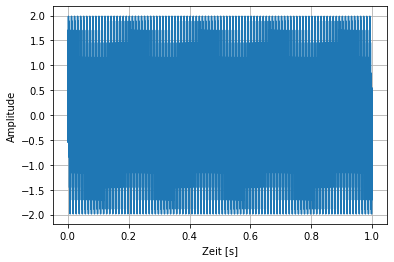

In [4]:
# Generierung Test Signals
sampleRate = 44100
T = 1
t = np.linspace(0,T,int(sampleRate*T))
x = np.sin(1000 * 2 * np.pi * t) + np.sin(100 * 2 * np.pi * t)

print(len(t), len(x), type(x))
plt.plot(t,x)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [5]:
ip_buffer = 2**18
Data_In = x
Data_out = Transmission(Data_In,ip_buffer)

Buffer Size:  262144
Frame Length:  262144  /  Frame Type:  <class 'numpy.ndarray'>
Input Buffer:  [         0       5119      10145 ... 4294957151 4294962177          0]
Output Buffer:  [    0  4383  8331 ...  9809 13916 17740]
Transmission successful


44100


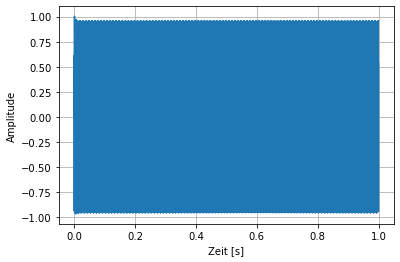

In [6]:
# Empfangene Daten plotten
y = Data_out
print(len(y))
plt.plot(t,y)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [7]:
# check status
print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Recv Status:  Error:  False Idle:  True Running:  True
Send Status:  Error:  False Idle:  True Running:  True
